# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import glob
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import multiprocessing as mp
import cv2
from scipy.signal import resample
import wave
from sklearn.model_selection import train_test_split
import ffmpeg
# import librosa
from pydub import AudioSegment
import io

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

import variables as var

In [3]:
# var.TO_PATH = "/content/drive/MyDrive/Thesis/PREP/sub_data"

In [ ]:
# prep_df = pd.read_csv("/content/drive/MyDrive/Thesis/PREP/prepped_df.csv")
prep_df = pd.read_csv("prepped_df.csv")

# remove unused columns
prep_df.drop(columns=["Title", "Description"], inplace=True)

prep_df

prep_df

,Id,Video_len,order of ECR,order of NAWP,Title,Description,Set,ECR,NAWP
0,5902367b4d7d4c38fe4638593ddea7ee,42.400000,0,0,zanzibarisland zanzibarbeach zanzibarlifest...,NaN,train,0.000000,0.000000
1,9be2d4d5e8d4bfd1f5ce59f51d7d96dd,15.582233,0,0,NaN,NaN,train,0.000000,0.000000
2,1d5a6586d42b5b0d69f48a7ba87fccfe,18.300000,0,0,NaN,استخراج السائل هذا للبشره smiling face with he...,train,0.000000,0.000000
3,1e9b26ba367a8ed559916599294bbfc1,45.866667,0,0,NaN,skullskullskullskullHAHAHA,train,0.000000,0.000000
4,e86dbca9869239fcf2d04373f9efd38e,29.880000,0,0,spotlightviral spotlight lmao viral trending,NaN,train,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
57833,58ec27987a35909f4006f136118c6940,21.033333,34494,131030,sportscommentator voiceover,NaN,test,0.269961,0.999466
57834,26e446b86f92faa89d88a58d03ea24bb,10.700000,47428,131047,12 Years or snapmemories in 12 seconds,In 12 seconds | 12 years of Snap Memories,test,0.371187,0.999596
57835,72ae9bac4dd52c9e6befc90d9bae710c,12.900000,35188,131086,Finally it’s pumpkin season psl pumpkinspice...,It’s PSL season,test,0.275392,0.999893
57836,f548dd1f4b64e5ca3f2c7780871a08c5,10.000000,1592,131090,thick thickgirls curves thickthighs curvey,NaN,test,0.012459,0.999924


In [5]:
downloaded_videos = os.listdir(var.DOWNLOAD_PATH + "/train")
downloaded_videos += os.listdir(var.DOWNLOAD_PATH + "/test")
downloaded_videos = [s.removesuffix(".mp4") for s in downloaded_videos]

prep_df = prep_df[prep_df["Id"].isin(downloaded_videos)]
prep_df

,Id,Video_len,order of ECR,order of NAWP,Title,Description,Set,ECR,NAWP
0,5902367b4d7d4c38fe4638593ddea7ee,42.400000,0,0,zanzibarisland zanzibarbeach zanzibarlifest...,NaN,train,0.000000,0.000000
1,9be2d4d5e8d4bfd1f5ce59f51d7d96dd,15.582233,0,0,NaN,NaN,train,0.000000,0.000000
2,1d5a6586d42b5b0d69f48a7ba87fccfe,18.300000,0,0,NaN,استخراج السائل هذا للبشره smiling face with he...,train,0.000000,0.000000
3,1e9b26ba367a8ed559916599294bbfc1,45.866667,0,0,NaN,skullskullskullskullHAHAHA,train,0.000000,0.000000
4,e86dbca9869239fcf2d04373f9efd38e,29.880000,0,0,spotlightviral spotlight lmao viral trending,NaN,train,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
57833,58ec27987a35909f4006f136118c6940,21.033333,34494,131030,sportscommentator voiceover,NaN,test,0.269961,0.999466
57834,26e446b86f92faa89d88a58d03ea24bb,10.700000,47428,131047,12 Years or snapmemories in 12 seconds,In 12 seconds | 12 years of Snap Memories,test,0.371187,0.999596
57835,72ae9bac4dd52c9e6befc90d9bae710c,12.900000,35188,131086,Finally it’s pumpkin season psl pumpkinspice...,It’s PSL season,test,0.275392,0.999893
57836,f548dd1f4b64e5ca3f2c7780871a08c5,10.000000,1592,131090,thick thickgirls curves thickthighs curvey,NaN,test,0.012459,0.999924


In [6]:
# def find_matching_ids(directory):
#     npz_ids = set()
#     wav_ids = set()

#     for file in os.listdir(directory):
#         if file.endswith(".npz"):
#             npz_ids.add(file[:-4])  # Remove .npz
#         elif file.endswith(".wav"):
#             wav_ids.add(file[:-4])  # Remove .wav

#     common_ids = npz_ids & wav_ids  # Find IDs present in both sets
#     return sorted(common_ids)

# existed_ids_train = find_matching_ids(var.TO_PATH + "/train")
# existed_ids_test = find_matching_ids(var.TO_PATH + "/test")

# prep_df = prep_df[prep_df["Id"].isin(existed_ids_train) | prep_df["Id"].isin(existed_ids_test)]
# prep_df.reset_index(drop=True, inplace=True)
# len(prep_df)

In [7]:
prep_df.sample(10)

,Id,Video_len,order of ECR,order of NAWP,Title,Description,Set,ECR,NAWP
40767,be45276145d48fe38fedd4d52c9da952,10.833333,126134,115967,NaN,he did this for 200$ fearful face,train,0.987165,0.884569
18172,534b4d122e2718ff5cf9f3052d87fbd1,16.133333,50101,40358,NaN,Cab corners looking eyesface with peeking eye,train,0.392106,0.307841
2019,3aad449204170a8408be79ad7a4c08ff,16.966667,5241,3047,sparklesCLOUTsparkles,This is how my dog asks for food or water if s...,train,0.041018,0.023242
9502,6f83fb03e1d9edc4d5728f5d47356f28,25.633333,29166,16785,NaN,I keep booping his nose face with tears of joy,train,0.228262,0.128032
17029,0b9357cf6b83ad7ee86980a32f5cd376,30.433333,70169,37054,NaN,NaN,train,0.549165,0.282639
10500,c52e8d817285542897d95cf4c866e9dd,19.000000,22663,18915,NaN,NaN,train,0.177368,0.144279
21877,94e6ea3d6701c278b29309b70e968dbc,21.966667,46860,52766,chiropractor chiropractic stressrelief str...,He really needed this!,train,0.366741,0.402487
48359,c6017cbd1efde25028ea960b731ada7b,25.000000,105857,127351,Are you MJ or Lebron eyes lebronjames michae...,Ray Allen on Bron eyes,train,0.828471,0.971404
24072,880ad669e1c6511502e03c279490a200,10.833333,72338,61289,NaN,"So, since I couldn't park where I live, I'm ha...",train,0.566140,0.467498
22438,5c05cc315aa87363a1c0673d955ee52e,31.800000,47836,54841,NaN,NaN,train,0.374380,0.418314


# Check distribution

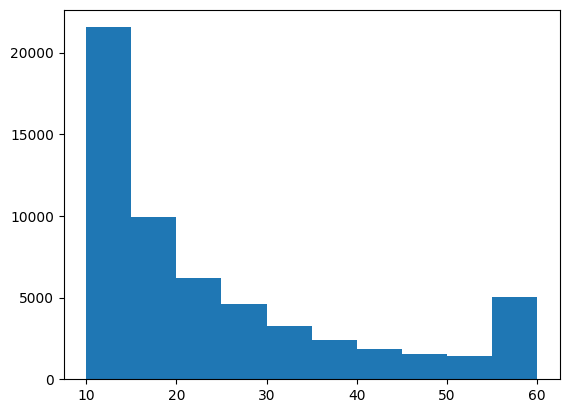

In [8]:
plt.hist(prep_df['Video_len'])
plt.show()

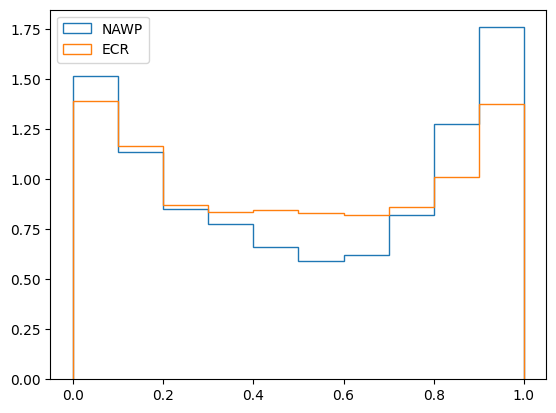

In [9]:
plt.hist(prep_df['NAWP'], density=True, histtype='step', label='NAWP')
plt.hist(prep_df['ECR'], density=True, histtype='step', label='ECR')
plt.legend()
plt.show()

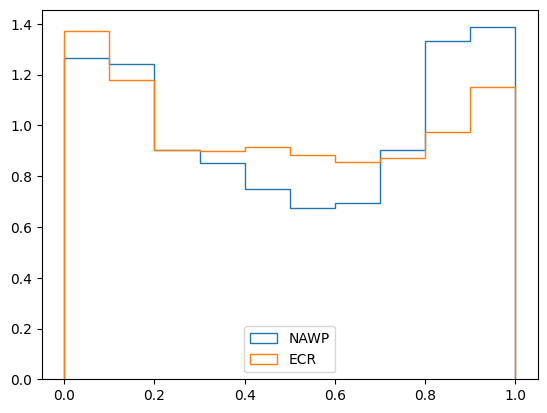

In [10]:
plt.hist(prep_df[prep_df['Video_len'] <= var.MAX_SECONDS]['NAWP'], density=True, histtype='step', label='NAWP')
plt.hist(prep_df[prep_df['Video_len'] <= var.MAX_SECONDS]['ECR'], density=True, histtype='step', label='ECR')
plt.legend()
plt.show()

In [11]:
prep_df = prep_df[prep_df['Video_len'] <= var.MAX_SECONDS]

In [12]:
prep_df['NAWP'].min(), prep_df['NAWP'].max(), prep_df['ECR'].min(), prep_df['ECR'].max()

(np.float64(0.0),
 np.float64(0.9999771167048056),
 np.float64(0.0),
 np.float64(1.0))

# Load data

In [13]:
sample_video = prep_df.sample(1).iloc[0]
sample_video

Id                               392a3da78447048b3223e0d3ac6a96f3
Video_len                                               10.341667
order of ECR                                                32974
order of NAWP                                               38970
Title                                                         NaN
Description      U got me laid last night, thanks pookiekiss mark
Set                                                         train
ECR                                                      0.258065
NAWP                                                     0.297254
Name: 17686, dtype: object

Sample ID: 392a3da78447048b3223e0d3ac6a96f3
Loaded Video Shape: (52, 224, 224, 3)
Loaded Audio Shape: (165326,)


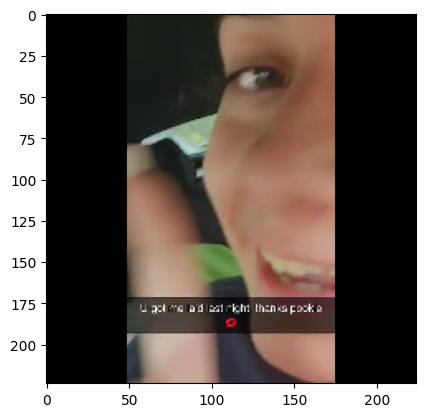

In [14]:
def load_video_audio(video_path, 
                    target_height=var.TARGET_FRAME_SIZE[0], target_width=var.TARGET_FRAME_SIZE[1], target_fps=var.VIDEO_FPS, 
                    target_sample_rate=var.AUDIO_FPS,
                    start=0, end=None):
    """
    Extracts video frames and audio from a video file between start and end seconds, with resizing and downsampling.
    """
    # ---- Extract Video Frames with Fixed FPS ----
    cap = cv2.VideoCapture(video_path)
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / original_fps

    if end is None or end > duration:
        end = duration

    start_frame = int(start * original_fps)
    end_frame = int(end * original_fps)
    frame_interval = original_fps / target_fps

    frames = []
    frame_idx = 0

    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    while cap.isOpened():
        current_pos = cap.get(cv2.CAP_PROP_POS_FRAMES)
        if current_pos >= end_frame:
            break

        ret, frame = cap.read()
        if not ret:
            break

        if frame_idx % round(frame_interval) == 0:
            h, w, _ = frame.shape

            # Resize with padding
            scale = min(target_width / w, target_height / h)
            new_w, new_h = int(w * scale), int(h * scale)
            resized_frame = cv2.resize(frame, (new_w, new_h))
            resized_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)

            padded_frame = np.zeros((target_height, target_width, 3), dtype=np.uint8)
            pad_top = (target_height - new_h) // 2
            pad_left = (target_width - new_w) // 2
            padded_frame[pad_top:pad_top+new_h, pad_left:pad_left+new_w] = resized_frame

            frames.append(padded_frame)

        frame_idx += 1

    cap.release()
    video_array = np.array(frames, dtype=np.uint8)

    # ---- Extract and Downsample Audio (Trimmed) ----
    ffmpeg_args = {
        'format': 'wav',
        'ar': target_sample_rate,
        'ac': 1
    }

    input_args = {}
    if start != 0 and end is not None:
        input_args['ss'] = start
        input_args['to'] = end

    out, _ = (
        ffmpeg
        .input(video_path, **input_args)
        .output("pipe:", **ffmpeg_args)
        .run(capture_stdout=True, capture_stderr=True)
    )

    audio = AudioSegment.from_file(io.BytesIO(out), format="wav")
    samples = np.array(audio.get_array_of_samples(), dtype=np.int16)

    return video_array, samples



print(f"Sample ID: {sample_video['Id']}")

video_loaded, audio_loaded = load_video_audio(os.path.join(var.DOWNLOAD_PATH, sample_video['Set'], sample_video['Id'] + ".mp4"),
                                              start=0, end=None)
print(f"Loaded Video Shape: {video_loaded.shape}")  # (num_frames, height, width, 3)
print(f"Loaded Audio Shape: {audio_loaded.shape}")

plt.imshow(video_loaded[0])
plt.show()

# Split scenes

In [15]:
prep_df.reset_index(drop=True, inplace=True)

In [16]:
splitted_df = pd.DataFrame({"Id": [], "Start": [], "End": []})

cur_files = os.listdir(var.SCENE_PATH)
num_csv_files = len(cur_files)

for csv_file in cur_files:
    tmp_df = pd.read_csv(var.SCENE_PATH + "/" + csv_file)
    splitted_df = pd.concat([splitted_df, tmp_df], axis=0)

splitted_df.reset_index(drop=True, inplace=True)
existed_ids = splitted_df['Id'].unique()
print("Existed ids:", len(existed_ids))
splitted_df

Existed ids: 4223


,Id,Start,End
0,9be2d4d5e8d4bfd1f5ce59f51d7d96dd,0.000000,15.582233
1,e86dbca9869239fcf2d04373f9efd38e,0.000000,14.188491
2,e86dbca9869239fcf2d04373f9efd38e,14.188491,29.880000
3,d641d9b30eac02cfcfee786feac8a04c,0.000000,13.680333
4,7f509bf510c87812428b202176ee19db,0.000000,0.834570
...,...,...,...
14018,7384bbfe040fcc87d9cc88c308c82a16,6.566667,12.266667
14019,628540b435bd7400b02fe268ec27187f,0.000000,10.714971
14020,628540b435bd7400b02fe268ec27187f,10.714971,11.957774
14021,628540b435bd7400b02fe268ec27187f,11.957774,16.190019


In [17]:
# only test a sample from prepared scenes
prep_df = prep_df[prep_df['Id'].isin(existed_ids)]
prep_df.reset_index(drop=True, inplace=True)
prep_df

,Id,Video_len,order of ECR,order of NAWP,Title,Description,Set,ECR,NAWP
0,9be2d4d5e8d4bfd1f5ce59f51d7d96dd,15.582233,0,0,NaN,NaN,train,0.000000,0.000000
1,e86dbca9869239fcf2d04373f9efd38e,29.880000,0,0,spotlightviral spotlight lmao viral trending,NaN,train,0.000000,0.000000
2,d641d9b30eac02cfcfee786feac8a04c,13.680333,0,253,NaN,NaN,train,0.000000,0.001930
3,7f509bf510c87812428b202176ee19db,22.500000,0,258,NaN,MY NEW INVENTION…. exploding headexploding hea...,train,0.000000,0.001968
4,61a565a53df7cb4080eb2c9f8bea3ae5,20.333333,1032,426,NaN,NaN,train,0.008077,0.003249
...,...,...,...,...,...,...,...,...,...
4218,41e69a10a619f170ce489242e3a0b978,17.300000,112326,130073,NaN,NaN,test,0.879099,0.992166
4219,a1f052b8da710021c328688d31e276a3,22.800000,126511,130307,Well… face with tears of joy disney fypシ f...,NaN,test,0.990115,0.993951
4220,a67a5e4a92b6435901de1a93a798e498,10.000000,38623,130497,NaN,NaN,test,0.302276,0.995400
4221,7384bbfe040fcc87d9cc88c308c82a16,12.266667,44439,130712,wnba allstargame vegas,Straight up bullying grinning face with smilin...,test,0.347794,0.997040


In [18]:
# from scenedetect import detect, AdaptiveDetector, split_video_ffmpeg
# # scene_list = detect(sample_video_path, AdaptiveDetector())
# # split_video_ffmpeg(sample_video_path, scene_list, output_dir='temp')

# scene_dict = {"Id": [], "Start": [], "End": []}

# countt = 0
# section_num = 500
# for i, row in tqdm(prep_df.iterrows(), desc="Preparing scenes", total=len(prep_df)):
#     if row['Id'] in existed_ids:
#         continue
    
#     vid_path = var.DOWNLOAD_PATH + "/" + row['Set'] + "/" + row['Id'] + ".mp4"
    
#     try:
#         scene_list = detect(vid_path, AdaptiveDetector())
#     except Exception as e:
#         print(f"Error processing {vid_path}: {e}")
    
#     if len(scene_list) == 0 or len(scene_list) == 1:
#         # If no scenes detected or only one scene, use the whole video
#         scene_dict['Id'].append(row['Id'])
#         scene_dict['Start'].append(0)
#         scene_dict['End'].append(row['Video_len'])
#     else:
#         for scene in scene_list:
#             start_time = scene[0].get_seconds()
#             end_time = scene[1].get_seconds()
#             # Append to the dictionary
#             scene_dict["Id"].append(row['Id'])
#             scene_dict["Start"].append(start_time)
#             scene_dict["End"].append(end_time)
    
#     if (countt + 1) % section_num == 0 or i == len(prep_df) - 1:
#         tmp_df = pd.DataFrame(scene_dict)
#         splitted_df = pd.concat([splitted_df, tmp_df], axis=0, ignore_index=True)
#         tmp_df.to_csv(var.SCENE_PATH + f"/scene_list_{num_csv_files}.csv", index=False)
#         num_csv_files += 1
#         scene_dict = {"Id": [], "Start": [], "End": []}

#     countt += 1

# splitted_df.reset_index(drop=True, inplace=True)
# print("Unique IDs in splitted_df:", len(splitted_df['Id'].unique()))
# splitted_df

# Create dataset

In [19]:
import torch
import numpy as np
import wave
import os

class VideoAudioDataset(torch.utils.data.Dataset):
    def __init__(self, df, prep_path):
        self.prep_path = prep_path
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        sample_id = sample["Id"]
        label = [sample["ECR"], sample["NAWP"]]

        video_array, audio_array = load_video_audio(os.path.join(self.prep_path, sample["Set"], sample_id + ".mp4"))

        # Convert to tensors
        video_tensor = torch.tensor(video_array, dtype=torch.float32)
        audio_tensor = torch.tensor(audio_array, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.float32)

        return {
            "id": sample_id,
            "video": video_tensor,
            "audio": audio_tensor,
            "label": label_tensor
        }

def collate_fn(batch, max_frames, max_audio_samples):
    """Custom collate function to pad frames and audio."""

    video_tensors = []
    audio_tensors = []
    labels = []
    ids = []
    sample_rates = []

    for sample in batch:
        video = sample["video"]
        audio = sample["audio"]
        num_frames = video.shape[0]
        num_audio_samples = audio.shape[0]

        # Pad video to 300 frames
        if num_frames < max_frames:
            pad_frames = max_frames - num_frames
            padded_video = torch.cat([video, torch.zeros((pad_frames, *video.shape[1:]))], dim=0)
        else:
            padded_video = video[:max_frames]

        # Pad audio to 960,000 samples
        if num_audio_samples < max_audio_samples:
            pad_audio = max_audio_samples - num_audio_samples
            padded_audio = torch.cat([audio, torch.zeros(pad_audio)], dim=0)
        else:
            padded_audio = audio[:max_audio_samples]

        video_tensors.append(padded_video)
        audio_tensors.append(padded_audio)
        labels.append(sample["label"])
        ids.append(sample["id"])

    return {
        "id": ids,
        "video": torch.stack(video_tensors),  # (batch_size, num_frames, C, H, W)
        "audio": torch.stack(audio_tensors),  # (batch_size, audio_length)
        "label": torch.stack(labels)  # (batch_size,)
    }

# Split data

In [20]:
train_df = prep_df[prep_df["Set"] == "train"]

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

test_df = prep_df[prep_df["Set"] == "test"]

len(train_df), len(val_df), len(test_df)

(2964, 741, 518)

# Define model

## Blip model

In [34]:
sample_video = prep_df.sample(1).iloc[0]
sample_video

Id                                681225a462227fdd07d1a78d5ade7ec0
Video_len                                                     14.6
order of ECR                                                 51130
order of NAWP                                                65157
Title            This might be my last day…  snapchatspotlight ...
Description                                                    NaN
Set                                                          train
ECR                                                        0.40016
NAWP                                                      0.497002
Name: 1859, dtype: object

First scene: Id       681225a462227fdd07d1a78d5ade7ec0
Start                                 0.0
End                              0.566667
Name: 4791, dtype: object
Loaded Video Shape: (3, 224, 224, 3)
Loaded Audio Shape: (234057,)


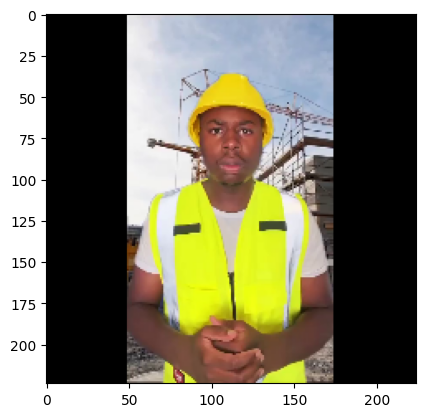

In [ ]:
# first scene
first_scene = splitted_df[splitted_df['Id'] == sample_video['Id']].iloc[0]
print("First scene:", first_scene)

video_loaded, audio_loaded = load_video_audio(os.path.join(var.DOWNLOAD_PATH, sample_video['Set'], sample_video['Id'] + ".mp4"),
                                              start=first_scene['Start'], end=first_scene['End'])
print(f"Loaded Video Shape: {video_loaded.shape}")  # (num_frames, height, width, 3)
print(f"Loaded Audio Shape: {audio_loaded.shape}")

sample_frame = video_loaded[0]
plt.imshow(sample_frame)

In [40]:
import torch
from transformers import AutoProcessor, BlipForConditionalGeneration

device = 'cuda' if torch.cuda.is_available() else 'cpu'

blip_processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
blip_model.eval()

def generate_captions(image, res_count=20, text='a picture of'):
    # Preprocess the image and text
    inputs = blip_processor(images=image, text=text, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Set the number of captions you want to generate
    with torch.no_grad():
        output = blip_model.generate(**inputs, max_length=50, num_beams=res_count, num_return_sequences=res_count)

    # Decode and print the captions
    captions = [blip_processor.decode(output[i], skip_special_tokens=True) for i in range(res_count)]
    
    # Remove the prompt
    captions = [caption.removeprefix("a picture of ") for caption in captions]
    return captions

candidate_captions = generate_captions(sample_frame, res_count=20) # Image.open("data/sample_image.jpg")
candidate_captions

['a man wearing a yellow safety vest',
 'a man in a yellow safety vest',
 'a construction worker wearing a yellow safety vest',
 'a man wearing a safety vest',
 'a construction worker wearing a safety vest',
 'a construction worker',
 'a man in a yellow safety vest and hard hat',
 'a man in a yellow vest and hard hat',
 'a construction worker standing in front of a building',
 'a man wearing a safety vest and hard hat',
 'a man wearing a yellow safety vest and hard hat',
 'a man in a safety vest and hard hat',
 'a man in a yellow vest and safety vest',
 'a construction worker in a yellow vest and hard hat',
 'a construction worker standing in front of a building site',
 'a construction worker in a yellow safety vest',
 'a construction worker in a yellow vest',
 'a construction worker wearing a safety vest and hard hat',
 'a man in a yellow safety vest and safety vest',
 'a construction worker wearing a yellow vest']

## InternVideo

In [ ]:
# temporarily switch to another due to GPU memory issues of InternVideo2 model

In [41]:
from transformers import AutoProcessor, AutoModel


processor = AutoProcessor.from_pretrained("microsoft/xclip-base-patch32")
model = AutoModel.from_pretrained("microsoft/xclip-base-patch32")


inputs = processor(
    text=candidate_captions,
    videos=list(video_loaded),
    return_tensors="pt",
    padding=True,
)

with torch.no_grad():
    outputs = model(**inputs)

logits_per_video = outputs.logits_per_video  # this is the video-text similarity score
probs = logits_per_video.softmax(dim=1)  # we can take the softmax to get the label probabilities
probs

/home/datlinux/XAI-4-YoutubeEngagement/.venv/lib/python3.12/site-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `VideoMAEImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


RuntimeError: shape '[0, 8, 768]' is invalid for input of size 2304

In [31]:
candidate_captions[probs.argmax()]

'a man standing on top of a woman in a room'

# Train step

# Training

# Evaluate

# Infer